# LSTM-Autoencoder Pluggable Fault Detector (Binary)

This notebook creates a binary anomaly detector using the trained LSTM-Autoencoder model.

**Task**: Binary anomaly detection (normal vs fault).

**Evaluation Dataset**: Pre-generated trajectory from notebook 04.

## Configuration & Imports

In [1]:
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

QUICK_MODE = False
if (DATA_DIR / 'detector_trajectory_quick.csv').exists():
    if not (DATA_DIR / 'detector_trajectory.csv').exists():
        QUICK_MODE = True
    else:
        quick_mtime = (DATA_DIR / 'detector_trajectory_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'detector_trajectory.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print('='*60)
print('LSTM-Autoencoder Binary Fault Detector')
if QUICK_MODE:
    print('QUICK MODE - Using short trajectory')
print(f'Device: {device}')
print('='*60)

LSTM-Autoencoder Binary Fault Detector
Device: cuda


## Define Model Architecture

In [2]:
class LSTMAutoencoder(nn.Module):
    """LSTM Autoencoder for anomaly detection (matches 25-lstm-autoencoder-final-training.ipynb)."""
    def __init__(self, input_size, hidden_size, num_layers, latent_size, dropout=0.0):
        super().__init__()
        
        self.encoder = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.encoder_fc = nn.Linear(hidden_size, latent_size)
        
        self.decoder_fc = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.LSTM(
            hidden_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.output_fc = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        _, (h, _) = self.encoder(x)
        latent = self.encoder_fc(h[-1])
        
        h_dec = self.decoder_fc(latent)
        h_dec = h_dec.unsqueeze(1).repeat(1, x.size(1), 1)
        dec_out, _ = self.decoder(h_dec)
        reconstruction = self.output_fc(dec_out)
        
        return reconstruction

print('Model class defined')

Model class defined


## Load Trained Model

In [3]:
print('\n[Step 1/5] Loading trained LSTM-Autoencoder model...')

model_path = MODEL_DIR / 'lstm_autoencoder_final.pt'
model_data = torch.load(model_path, map_location=device, weights_only=False)

features = model_data['features']
scaler_mean = model_data['scaler_mean']
scaler_scale = model_data['scaler_scale']
threshold = model_data['threshold']

hp = model_data['hyperparameters']
model = LSTMAutoencoder(
    input_size=len(features),
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    latent_size=hp['latent_size'],
    dropout=hp['dropout']
)
model.load_state_dict(model_data['model_state_dict'])
model.to(device)
model.eval()

print(f'Model loaded from {model_path}')
print(f'  Features: {len(features)}')
print(f'  Anomaly threshold: {threshold:.6f}')


[Step 1/5] Loading trained LSTM-Autoencoder model...


Model loaded from ../outputs/models/lstm_autoencoder_final.pt
  Features: 52
  Anomaly threshold: 0.730866


## Load Trajectory

In [4]:
print('\n[Step 2/5] Loading pre-generated trajectory...')

traj_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}.csv'
traj_df = pd.read_csv(traj_file)

info_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}_info.json'
with open(info_file) as f:
    traj_info = json.load(f)

print(f'Loaded trajectory: {len(traj_df)} samples, {traj_info["total_hours"]} hours')


[Step 2/5] Loading pre-generated trajectory...


Loaded trajectory: 875 samples, 42 hours


## Run Detection

In [5]:
print('\n[Step 3/5] Running anomaly detection...')
detect_start = time.time()

seq_len = model_data['hyperparameters']['sequence_length']
xmeas_cols = [f'xmeas_{i}' for i in range(1, 42)]
xmv_cols = [f'xmv_{i}' for i in range(1, 12)]
feature_cols = xmeas_cols + xmv_cols

buffer = np.zeros((seq_len, len(features)), dtype=np.float32)
buffer_count = 0

detections = []
for idx, row in traj_df.iterrows():
    feat = row[feature_cols].values.astype(np.float32)
    feat_scaled = (feat - scaler_mean) / scaler_scale
    
    buffer = np.roll(buffer, -1, axis=0)
    buffer[-1] = feat_scaled
    buffer_count += 1
    
    if buffer_count >= seq_len:
        seq = torch.tensor(buffer).unsqueeze(0).to(device)
        with torch.no_grad():
            recon = model(seq)
            error = ((seq - recon) ** 2).mean().item()
        is_fault = int(error > threshold)
    else:
        error = 0.0
        is_fault = 0
    
    true_fault = int(row['faultNumber'] != 0)
    
    detections.append({
        'step': int(row['step']),
        'time_hours': row['time_hours'],
        'recon_error': error,
        'predicted_fault': is_fault,
        'true_fault': true_fault,
        'true_class': int(row['faultNumber'])
    })

detections_df = pd.DataFrame(detections)
detections_df['correct'] = detections_df['predicted_fault'] == detections_df['true_fault']

print(f'Detection complete in {time.time() - detect_start:.2f}s')
print(f'  Samples: {len(detections_df)}')
print(f'  Accuracy: {detections_df["correct"].mean():.4f}')


[Step 3/5] Running anomaly detection...


Detection complete in 0.87s
  Samples: 875
  Accuracy: 0.4720


## Compute Metrics

In [6]:
print('\n[Step 4/5] Computing metrics...')

y_true = detections_df['true_fault'].values
y_pred = detections_df['predicted_fault'].values
recon_errors = detections_df['recon_error'].values

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# AUC only if we have both classes
if len(np.unique(y_true)) > 1:
    auc = roc_auc_score(y_true, recon_errors)
else:
    auc = 0.0

print('\nBinary Detection Performance:')
print('='*50)
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')
print(f'AUC-ROC:   {auc:.4f}')
print('='*50)


[Step 4/5] Computing metrics...

Binary Detection Performance:
Accuracy:  0.4720
Precision: 0.4357
Recall:    0.9972
F1 Score:  0.6065
AUC-ROC:   0.6281


## Visualizations

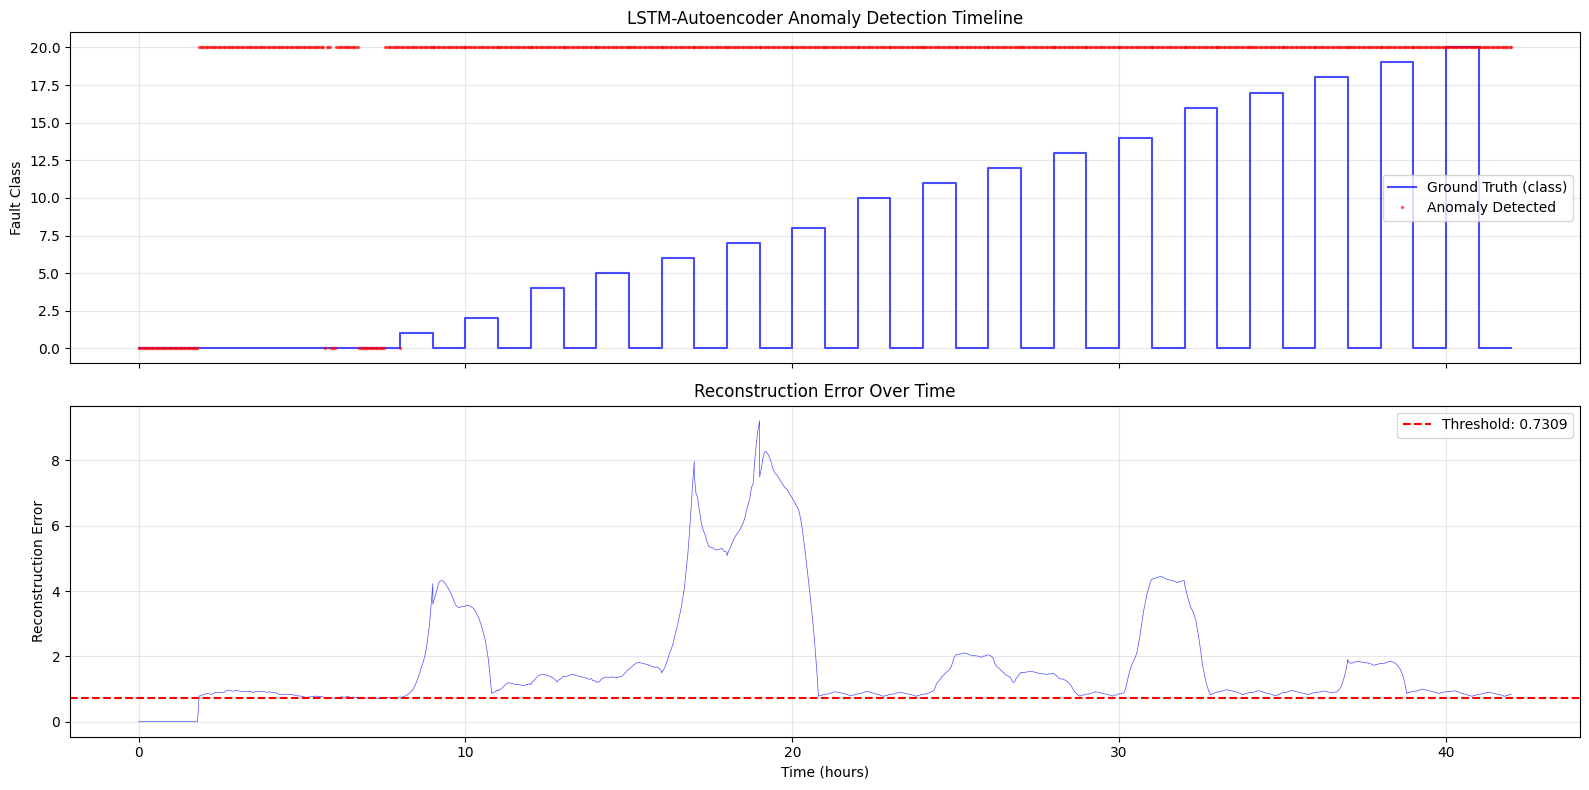

Saved to ../outputs/figures/lstm_autoencoder_detector_timeline.png


In [7]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

time_h = detections_df['time_hours'].values

ax = axes[0]
ax.plot(time_h, detections_df['true_class'], 'b-', linewidth=1.5, label='Ground Truth (class)', alpha=0.7)
ax.plot(time_h, detections_df['predicted_fault'] * detections_df['true_class'].max(), 'r.', markersize=3, label='Anomaly Detected', alpha=0.5)
ax.set_ylabel('Fault Class')
ax.set_title('LSTM-Autoencoder Anomaly Detection Timeline')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(time_h, recon_errors, 'b-', linewidth=0.5, alpha=0.7)
ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
ax.set_ylabel('Reconstruction Error')
ax.set_xlabel('Time (hours)')
ax.set_title('Reconstruction Error Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'lstm_autoencoder_detector_timeline{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

## Save Results

In [8]:
print('\n[Step 5/5] Saving results...')

results = {
    'model': 'LSTM-Autoencoder',
    'detector_type': 'binary_anomaly',
    'quick_mode': QUICK_MODE,
    'simulation': {
        'total_hours': traj_info['total_hours'],
        'total_samples': len(detections_df)
    },
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'auc_roc': float(auc)
    },
    'threshold': float(threshold)
}

output_file = METRICS_DIR / f'lstm_autoencoder_detector_results{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f'Saved to {output_file}')


[Step 5/5] Saving results...
Saved to ../outputs/metrics/lstm_autoencoder_detector_results.json


In [9]:
print('\n' + '='*60)
print('LSTM-Autoencoder Binary Detector Complete!')
if QUICK_MODE:
    print('(Quick mode)')
print('='*60)
print(f'\nAccuracy: {accuracy:.4f}')
print(f'F1: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print('='*60)


LSTM-Autoencoder Binary Detector Complete!

Accuracy: 0.4720
F1: 0.6065
Recall: 0.9972
